# Modules


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn import datasets

sns.set()


In [3]:
# load & format iris dataset
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns = iris.feature_names)
iris_df['species'] = [iris.target_names[i] for i in iris.target]

# petal lenghts of each species
setosa_petal_length = iris_df.loc[iris_df['species'] == 'setosa', 'petal length (cm)'].to_numpy()
versicolor_petal_length = iris_df.loc[iris_df['species'] == 'versicolor', 'petal length (cm)'].to_numpy()
virginica_petal_length = iris_df.loc[iris_df['species'] == 'virginica', 'petal length (cm)'].to_numpy()


In [4]:
def ecdf(data):
    """
    returns X and Y arrays 
    for the ECDF of a 1D array of measuremetns.
    """
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n   # 1/n to 1 in equally spaced increments
    return x, y


___

# Statistical Inference

Probabilistic reasoning allows us to describe uncertainty. It is the process by which we go from measured data to probabilistic conclusions about what we might expect if we collected the same data again and draw more general conclusions from relatively few data or observations.

Statistical inference involves taking your data to probabilistic conclusions about what you would expect if you took even more data, and you can make decisions based on these conclusions. Data are almost never exactly the same when acquired again, and probability allows us to say how much we expect them to vary.

Given a set of data, statistical inference describe probabilistically what you might expect if those data were acquired again. Repeating measurements provide an indication of the range of values we can expect the value of interest can take.

If the observed data follows a common distribution, we can use its properties to infer conclusions about unseen data.

___

# Parameter Estimation

If we believe the process that generates our data follows a given probability distribution, a major goal of statistical inference is to estimate the values of these parameters, which allows us to concisely and unambiguously describe our data and draw conclusions from it. The optimal parameters for the model are directly computed from the data itself.

## Bootstrap Samples

Slight variations in the measured data would lead to slightly different parameters. We can simulate getting new data (i.e. what we would get from an infinitude of experiments) by bootstrapping: resampling our data with replacement and recomputing the parameter(s) of interest.

+ each new sample is called a bootstrap sample.
+ its summary statistics is called a bootstrap replicate.

We can: 

+ plot the ECDF of the bootstrap replicates to get the probability distribution of the parameter.
+ calculate confidence intervals of the statistics. If we repeated measurements over and over again, p% of the observed values would lie within the p% confidence interval.


In [10]:
def bootstrap_sample_1d(data):
    """Generate bootstrap sample of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return bs_sample

def bootstrap_replicate_1d(bs_sample, func):
    """Generate bootstrap replicate of 1D data."""
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_samples = np.empty((size, len(data)))
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_samples[i, :] = bootstrap_sample_1d(data)
        bs_replicates[i] = bootstrap_replicate_1d(bs_samples[i], func)

    return bs_samples, bs_replicates


## Population Mean

The probability distribution of the sample mean will always be normally distributed if some conditions are met. In this case:
+ mu 
+ standard error of the mean = $\sigma / \sqrt{n}$


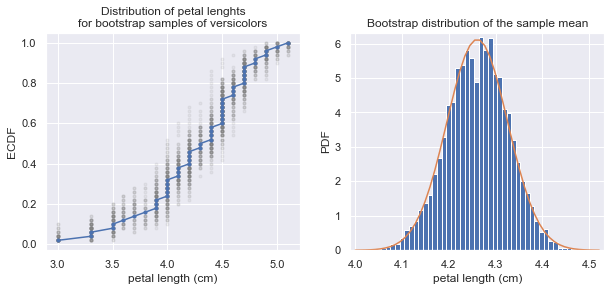

In [6]:
# fig & seed
seed = np.random.seed(42)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (2 * 5, 4))

# plot the ECDF of 50 bootstrap samples
for _ in range(50):
    # Generate bootstrap sample: bs_sample
    bs_sample = bootstrap_sample_1d(versicolor_petal_length)

    # Compute and plot ECDF from bootstrap sample
    x, y = ecdf(bs_sample)
    _ = ax1.plot(x, y, marker='.', linestyle='none',
                 color='gray', alpha=0.1)

# Compute and plot ECDF from original data
x, y = ecdf(versicolor_petal_length)
_ = ax1.plot(x, y, marker='.')

# Make margins and label axes
plt.margins(0.02)
_ = ax1.set_xlabel('petal length (cm)')
_ = ax1.set_ylabel('ECDF')
_ = ax1.set_title('Distribution of petal lenghts\nfor bootstrap samples of versicolors')



# Take 10,000 bootstrap replicates of the mean
bs_replicates = draw_bs_reps(versicolor_petal_length, np.mean, size=10000)

# Make a histogram of the results
_ = ax2.hist(bs_replicates, bins=50, normed=True)
_ = ax2.set_xlabel('petal length (cm)')
_ = ax2.set_ylabel('PDF')
_ = ax2.set_title('Bootstrap distribution of the sample mean')

# the distribution of the sample mean is normally distributed around the mean
bs_mu = np.mean(bs_replicates) # mean of the mean
bs_std = np.std(bs_replicates) # standard error of the mean

xmin = bs_mu - 4 * bs_std
xmax = bs_mu + 4 * bs_std
x = np.linspace(xmin, xmax, 50)

_ = ax2.plot(x, stats.norm.pdf(x, bs_mu, bs_std))


In [7]:
# compare the theoritical standard error of the mean (SEM) vs from bootstrap replicates
sem = np.std(versicolor_petal_length) / np.sqrt(len(versicolor_petal_length))
bs_std = np.std(bs_replicates)
print('SEM: {:.3} - Bootstraps SD: {:.3}'.format(sem, bs_std))

# confidence intervals
ci = np.percentile(bs_replicates, [2.5, 97.5])
print('95% Confidence Interval: P025 = {:0.2f}, P050 = {:0.2f}, P975 = {:0.2f}'.format(ci[0], bs_replicates.mean(), ci[1]))


SEM: 0.0658 - Bootstraps SD: 0.0652
95% Confidence Interval: P025 = 4.13, P050 = 4.26, P975 = 4.39


## Population Variance

The distribution of the sampling variance:
+ is not normal.
+ is always skewed to the right.
+ has a mean equal to the population variance. 

If the population from which samples are selected follows a normal distribution, the sampling distribution of sample variances [follows a chi-square distribution](https://online.stat.psu.edu/stat414/lesson/26/26.3). Its degrees of freedom are equal to the sample size minus one (n-1) degrees of freedom. If n is large, it can be [approximated](https://www.vosesoftware.com/riskwiki/NormalapproximationtotheChiSquareddistribution.php) by a normal distribution (n-1), sqrt(2 * (n-1)).


In [11]:
# 10,000 bootstrap replicates of the variance
seed = np.random.seed(42)
bs_samples, bs_replicates = draw_bs_reps(versicolor_petal_length, np.var, size=10000)

# mean and standard deviation of the sampling distribution of the variance
bs_mu = np.mean(bs_replicates) # mean of the variance
bs_std = np.std(bs_replicates) # standard error of the variance

# bs_replicates coeff
chi_df = len(versicolor_petal_length) - 1
chi_coeff = chi_df / versicolor_petal_length.var()


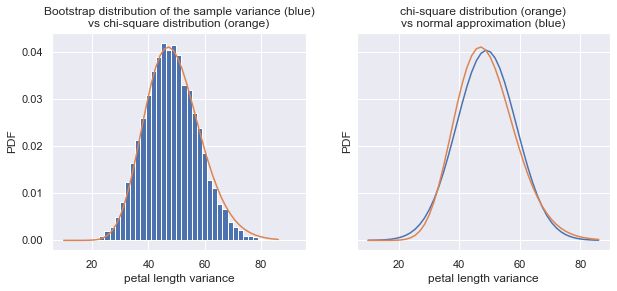

In [12]:
# fig & seed
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (2 * 5, 4), sharey=True)

# Make a histogram of the results
_ = ax1.hist(chi_coeff * bs_replicates, bins=40, density=True, stacked=True)

# chi-square distribution
xmin = bs_mu - 4 * bs_std
xmax = bs_mu + 4 * bs_std
x = np.linspace(chi_coeff * xmin, chi_coeff * xmax, 50)
_ = ax1.plot(x, stats.chi2.pdf(x, chi_df))

# chi vs normal
_ = ax2.plot(x, stats.norm.pdf(x, chi_df, np.sqrt(2*chi_df)))
_ = ax2.plot(x, stats.chi2.pdf(x, chi_df))

# labels
_ = ax1.set_xlabel('petal length variance')
_ = ax1.set_ylabel('PDF')
_ = ax2.set_xlabel('petal length variance')
_ = ax2.set_ylabel('PDF')

# titles
_ = ax1.set_title('Bootstrap distribution of the sample variance (blue)\nvs chi-square distribution (orange)')
_ = ax2.set_title('chi-square distribution (orange)\nvs normal approximation (blue)')


___

# Hypothesis Testing

You now know how to define and estimate parameters of a given model. But the question remains: how reasonable is it that our observed data are actually described by our model? Hypothesis testing is an assessment of how reasonable the observed data are assuming a hypothesis is true; it is called the null hypothesis.

What about the data do we assess, and how do we quantify the assessment? We use a test statistic: a single number that can be computed from observed data and from the data you generate under the null hypothesis. It serves as a basis of comparison between what the null hypothesis predicts and what we actually observed.

_Note: the test statistic should be relevant to the question you are trying to answer._

_Note2: Hypothesis testing is sometimes called Null Hypothesis Significance Testing or NHST._



___

# TESTING FOR NORMALITY
## Q-Q Plots

### Construction

Q–Q (quantile-quantile) plots compare two probability distributions by plotting their quantiles against each other. They are commonly used to compare a dataset to a theoretical model, providing a graphical assessment of "goodness of fit" rather than a numerical summary.

_Note: When the two datasets have the same size, the Q_Q plot orders each set in increasing order and pairs off the corresponding values. Otherwise, it is necessary to interpolate quantile estimates for the smallest dataset._

_Note: in an ordered sample, the kth-smallest value is called its [kth-order statistic](https://en.wikipedia.org/wiki/Order_statistic). For the normal distribution, tje order statistics are called [rankits](https://en.wikipedia.org/wiki/Rankit)._


### Interpretation

If the two distributions being compared are similar, the points in the Q–Q plot will approximately lie on the line y = x. If the distributions are linearly related, the points in the Q–Q plot will approximately lie on a line, but not necessarily on the line y = x.

A non-linear pattern suggests the two datasets don't have the same probability distribution.


### Examples

The examples below show PDFs, CDFs and QQ-plots for a few common distributions. Note that the PDF of actual samples can only be approximated by histograms and Kernel Density Estimates, so the CDF will be easier to analyze.

![qqplot](../../img/qq-plot.png)


## Shapiro-Wilk Test




## Jarque-Bera Test

The Jarque–Bera test is a goodness-of-fit test based on the sample skewness and kurtosis: its null hypothesis states that both skewness and excess kurtosis are zero. If the data comes from a normal distribution, the JB test statistic asymptotically follows a chi-squared distribution with two degrees of freedom.

The chi-squared approximation is overly sensitive for small samples, often rejecting the null hypothesis when it is true (large Type I error rate). This is why this test is only recommended for large samples (n > 2000).

_Note: some implementations interpolate p-values for small samples via Monte-Carlo simulations, in order to account for discrepancies between calculations and true alpha values._
